<a target="_blank" href="https://colab.research.google.com/github/Teghfo/deeplearning-bootcamp-pytorch/blob/master/notebooks/06-ImageSegmentation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#### This Exercise is from the Chollet Github , Image Segmentation
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb 

In [65]:
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchsummary import summary
from torchmetrics import Accuracy

In [12]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-02-09 08:23:05--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-02-09 08:23:05--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-02-09 08:23:06--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import os
from glob import glob

input_dir = r"imagesegment\images\images"
target_dir = r"images\annotations\trimaps"

input_img_paths = sorted(glob(input_dir + "/*.jpg"))
target_paths = sorted(glob(target_dir + "/*.png"))

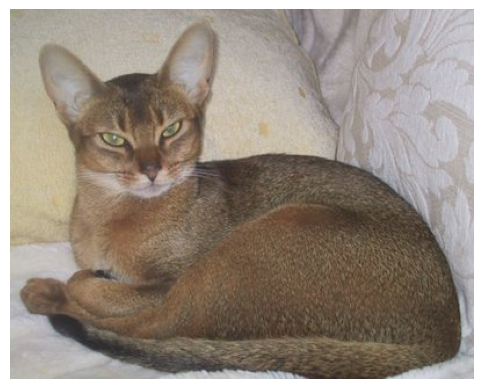

In [5]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(input_img_paths[13])[:, : , ::-1]

plt.axis("off")
plt.imshow(img)

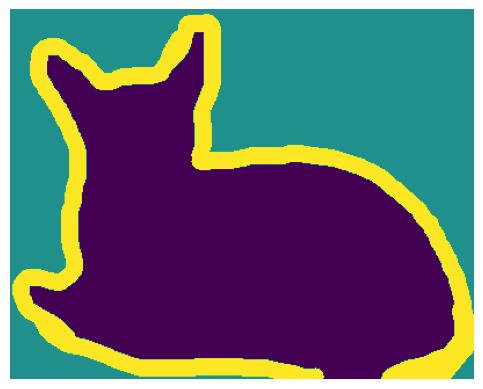

In [6]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = cv2.imread(target_paths[13])
display_target(img)

In [5]:
class SegmentDataset(Dataset):
  def __init__(self, image_dir, target_dir, img_size=(200,200),
               target_size = (200,200),random_state=1337, train=True, transform=None):

    all_images_path = sorted(glob(image_dir + "/*.jpg"))
    all_targets_path = sorted(glob(target_dir + "/*.png"))


    random.Random(random_state).shuffle(all_images_path)
    random.Random(random_state).shuffle(all_targets_path)

    self.transform = transform
    self.img_size = img_size
    self.target_size = target_size

    num_val_samples = 1000
    if train:
      self.images_path = all_images_path[num_val_samples:]
      self.targets_path = all_targets_path[num_val_samples:]
    else:
      self.images_path = all_images_path[:num_val_samples]
      self.targets_path = all_targets_path[:num_val_samples]

  def __len__(self):
    return len(self.images_path)

  def image_read(self, path, size):
    im = Image.open(path).convert("RGB")
    im = im.resize(size)
    return np.array(im)


  def __getitem__(self, idx):
    image_path = self.images_path[idx]
    target_path = self.targets_path[idx]
    image = self.image_read(image_path,self.img_size)
    target = self.image_read(target_path,self.target_size)[:,:,0]
    if self.transform:
      image = self.transform(image)
    else:
      image = transforms.ToTensor()(image)
    target = torch.from_numpy(target.astype("uint8")) - 1
    return image.float(), target

In [6]:
train_dataset = SegmentDataset(input_dir, target_dir, train=True)
val_dataset = SegmentDataset(input_dir, target_dir, train=False)

In [30]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64)

In [10]:
def display_target_tensor(target_tensor):
    normalized_tensor = target_tensor * 127
    plt.figure()
    plt.axis("off")
    plt.imshow(normalized_tensor)

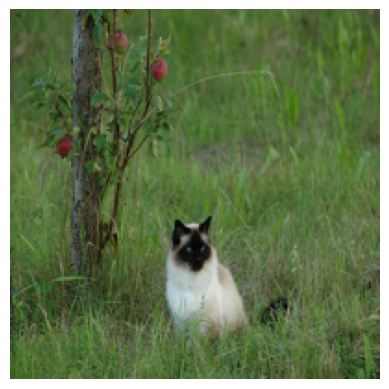

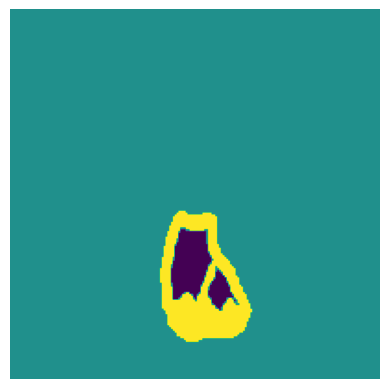

In [82]:
im, target = next(iter(train_dl))
plt.axis("off")
plt.imshow(im[0].permute(1, 2, 0))
display_target_tensor(target[0])

### Class_Exercise Architecture

In [13]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DownsampleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(UpsampleBlock, self).__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, stride=2, padding=1,output_padding=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv_transpose1(x)
        x = self.activation(x)
        x = self.conv_transpose2(x)
        x = self.activation(x)
        return x

class CustomModel(nn.Module):
    def __init__(self, img_size, num_classes):
        super(CustomModel, self).__init__()
        
        self.img_size = img_size
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            DownsampleBlock(3, 64),
            DownsampleBlock(64, 128),
            DownsampleBlock(128, 256)
        )
        
        self.decoder = nn.Sequential(
        
            UpsampleBlock(256, 128),
            UpsampleBlock(128, 64),
            UpsampleBlock(64,64)
        )
        
        self.classifier=nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x= self.classifier(x)     
        return x

In [14]:
custom_model= CustomModel((200,200),3).to(device)
custom_model

CustomModel(
  (encoder): Sequential(
    (0): DownsampleBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (1): DownsampleBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (2): DownsampleBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
  )
  (decoder): Sequential(
    (0): UpsampleBlock(
      (conv_transpose1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_transpose2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (activa

In [15]:

summary(custom_model, (3, 200, 200))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 25, 25]         --
|    └─DownsampleBlock: 2-1              [-1, 64, 100, 100]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 100, 100]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 100, 100]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 100, 100]        36,928
|    |    └─ReLU: 3-4                    [-1, 64, 100, 100]        --
|    └─DownsampleBlock: 2-2              [-1, 128, 50, 50]         --
|    |    └─Conv2d: 3-5                  [-1, 128, 50, 50]         73,856
|    |    └─ReLU: 3-6                    [-1, 128, 50, 50]         --
|    |    └─Conv2d: 3-7                  [-1, 128, 50, 50]         147,584
|    |    └─ReLU: 3-8                    [-1, 128, 50, 50]         --
|    └─DownsampleBlock: 2-3              [-1, 256, 25, 25]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 25, 25]         29

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 25, 25]         --
|    └─DownsampleBlock: 2-1              [-1, 64, 100, 100]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 100, 100]        1,792
|    |    └─ReLU: 3-2                    [-1, 64, 100, 100]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 100, 100]        36,928
|    |    └─ReLU: 3-4                    [-1, 64, 100, 100]        --
|    └─DownsampleBlock: 2-2              [-1, 128, 50, 50]         --
|    |    └─Conv2d: 3-5                  [-1, 128, 50, 50]         73,856
|    |    └─ReLU: 3-6                    [-1, 128, 50, 50]         --
|    |    └─Conv2d: 3-7                  [-1, 128, 50, 50]         147,584
|    |    └─ReLU: 3-8                    [-1, 128, 50, 50]         --
|    └─DownsampleBlock: 2-3              [-1, 256, 25, 25]         --
|    |    └─Conv2d: 3-9                  [-1, 256, 25, 25]         29

In [8]:
import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        init.kaiming_uniform_(m.weight.data, nonlinearity='relu')  
        if m.bias is not None:
            init.constant_(m.bias.data, 0.0) 

In [ ]:
custom_model=custom_model.apply(weights_init)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(custom_model.parameters(), lr=1e-3)


### Training 

In [9]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    acc_train = Accuracy(task='MULTICLASS',num_classes=3).to(device)

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        acc_train(outputs, targets.long())
    train_loss = running_loss / len(loader)
   

    return train_loss, 100.*acc_train.compute().item()


In [10]:
def evaluation(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    acc_valid = Accuracy(task='MULTICLASS',num_classes=3).to(device)

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.long())

            running_loss += loss.item()
            acc_valid(outputs, targets.long())
    valid_loss = running_loss / len(loader)
    

    return valid_loss, 100.*acc_valid.compute().item()

In [21]:
num_epochs = 10

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(custom_model, train_dl, criterion, optimizer)
    valid_loss, valid_accuracy = evaluation(custom_model, val_dl, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(valid_loss)
    test_accuracies.append(valid_accuracy)
    
    # if epoch % 10 == 0:
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f} | Validation Accuracy: {valid_accuracy:.4f}")
    print()

 10%|█         | 1/10 [01:10<10:36, 70.72s/it]

Epoch 1/10:
Train Loss: 3032.1433 | Train Accuracy: 57.5539
Validation Loss: 0.8388 | Validation Accuracy: 59.1848



 20%|██        | 2/10 [02:24<09:42, 72.76s/it]

Epoch 2/10:
Train Loss: 0.8292 | Train Accuracy: 61.3771
Validation Loss: 0.8108 | Validation Accuracy: 66.1170



 30%|███       | 3/10 [04:14<10:27, 89.60s/it]

Epoch 3/10:
Train Loss: 0.7721 | Train Accuracy: 67.3609
Validation Loss: 0.7106 | Validation Accuracy: 71.1030



 40%|████      | 4/10 [05:41<08:52, 88.73s/it]

Epoch 4/10:
Train Loss: 0.7294 | Train Accuracy: 69.4724
Validation Loss: 0.6991 | Validation Accuracy: 71.3715



 50%|█████     | 5/10 [08:02<08:56, 107.24s/it]

Epoch 5/10:
Train Loss: 0.6780 | Train Accuracy: 72.0606
Validation Loss: 0.6287 | Validation Accuracy: 74.2374



 60%|██████    | 6/10 [09:20<06:29, 97.46s/it] 

Epoch 6/10:
Train Loss: 0.6559 | Train Accuracy: 73.0970
Validation Loss: 0.6629 | Validation Accuracy: 71.2943



 70%|███████   | 7/10 [10:28<04:23, 87.82s/it]

Epoch 7/10:
Train Loss: 0.6272 | Train Accuracy: 74.3826
Validation Loss: 0.5765 | Validation Accuracy: 76.9556



 80%|████████  | 8/10 [11:36<02:43, 81.51s/it]

Epoch 8/10:
Train Loss: 0.6544 | Train Accuracy: 73.9260
Validation Loss: 0.5808 | Validation Accuracy: 76.7733



 90%|█████████ | 9/10 [12:43<01:16, 76.91s/it]

Epoch 9/10:
Train Loss: 0.5833 | Train Accuracy: 76.4707
Validation Loss: 0.6239 | Validation Accuracy: 73.6493



100%|██████████| 10/10 [13:48<00:00, 82.90s/it]

Epoch 10/10:
Train Loss: 0.5678 | Train Accuracy: 77.2879
Validation Loss: 0.5327 | Validation Accuracy: 78.7480



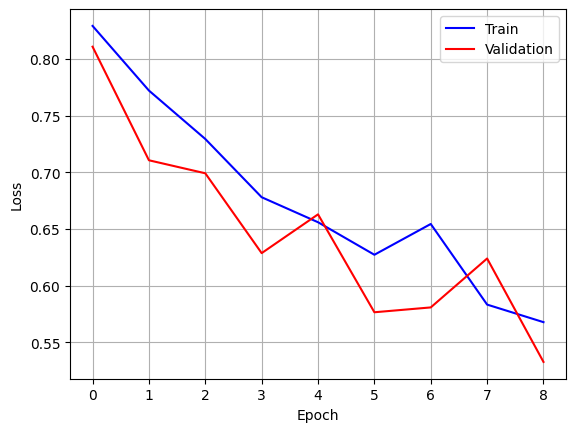

In [26]:
plt.plot(range(num_epochs-1), train_losses[1:], 'b-', label='Train')
plt.plot(range(num_epochs-1), test_losses[1:], 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

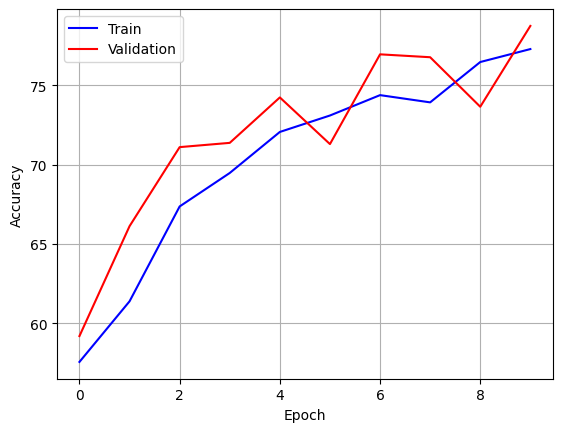

In [27]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

### With U-Net

In [52]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)  # Removed padding
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        # Resize skip tensor to match the spatial dimensions of x
        skip_resized = F.interpolate(skip, size=x.size()[2:], mode='nearest')
        x = torch.cat([x, skip_resized], dim=1)  # Concatenate along channel dimension
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()

        # Contracting layers (encoder)
        self.contracting_layer1 = encoder_block(in_channels, 64)
        self.contracting_layer2 = encoder_block(64, 128)
        self.contracting_layer3 = encoder_block(128, 256)
        self.contracting_layer4 = encoder_block(256, 512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Expansive layers (decoder)
        self.expansive_layer1 = decoder_block(1024, 512)
        self.expansive_layer2 = decoder_block(512, 256)
        self.expansive_layer3 = decoder_block(256, 128)
        self.expansive_layer4 = decoder_block(128, 64)

        # Final convolutional layer
        self.output_layer = nn.Conv2d(64, num_classes, kernel_size=1, padding=0)

    def forward(self, inputs):
        # Contracting layers (encoder)
        cl1, p1 = self.contracting_layer1(inputs)
        cl2, p2 = self.contracting_layer2(p1)
        cl3, p3 = self.contracting_layer3(p2)
        cl4, _ = self.contracting_layer4(p3)

        # Bottleneck
        bottleneck = self.bottleneck(cl4)

        # Expansive layers (decoder)
        ex1 = self.expansive_layer1(bottleneck, cl4)
        ex2 = self.expansive_layer2(ex1, cl3)
        ex3 = self.expansive_layer3(ex2, cl2)
        ex4 = self.expansive_layer4(ex3, cl1)

        # Final convolutional layer
        output = self.output_layer(ex4)

        # Resize output tensor to match the spatial dimensions of the target
        output = F.interpolate(output, size=(200, 200), mode='bilinear', align_corners=False)

        return output

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [54]:
unet_model= build_unet(3,3).to(device)
unet_model

build_unet(
  (contracting_layer1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (contracting_layer2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (po

In [55]:
summary(unet_model, (3, 200, 200))

Layer (type:depth-idx)                   Output Shape              Param #
├─encoder_block: 1-1                     [-1, 64, 200, 200]        --
|    └─conv_block: 2-1                   [-1, 64, 200, 200]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 200, 200]        1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 200, 200]        128
|    |    └─ReLU: 3-3                    [-1, 64, 200, 200]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 200, 200]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 200, 200]        128
|    |    └─ReLU: 3-6                    [-1, 64, 200, 200]        --
|    └─MaxPool2d: 2-2                    [-1, 64, 100, 100]        --
├─encoder_block: 1-2                     [-1, 128, 100, 100]       --
|    └─conv_block: 2-3                   [-1, 128, 100, 100]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 100, 100]       73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 100, 100]       256
|

Layer (type:depth-idx)                   Output Shape              Param #
├─encoder_block: 1-1                     [-1, 64, 200, 200]        --
|    └─conv_block: 2-1                   [-1, 64, 200, 200]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 200, 200]        1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 200, 200]        128
|    |    └─ReLU: 3-3                    [-1, 64, 200, 200]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 200, 200]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 200, 200]        128
|    |    └─ReLU: 3-6                    [-1, 64, 200, 200]        --
|    └─MaxPool2d: 2-2                    [-1, 64, 100, 100]        --
├─encoder_block: 1-2                     [-1, 128, 100, 100]       --
|    └─conv_block: 2-3                   [-1, 128, 100, 100]       --
|    |    └─Conv2d: 3-7                  [-1, 128, 100, 100]       73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 100, 100]       256
|

In [56]:
unet_model=unet_model.apply(weights_init)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(unet_model.parameters(), lr=1e-3)

##### because of memory allocate error I had to reduce batch size

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=5)

In [63]:
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(unet_model, train_dl, criterion, optimizer)
    valid_loss, valid_accuracy = evaluation(unet_model, val_dl, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(valid_loss)
    test_accuracies.append(valid_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f} | Validation Accuracy: {valid_accuracy:.4f}")
    print()

 10%|█         | 1/10 [22:26<3:21:57, 1346.43s/it]

Epoch 1/10:
Train Loss: 0.6697 | Train Accuracy: 72.2362
Validation Loss: 0.5238 | Validation Accuracy: 79.5797



 20%|██        | 2/10 [33:25<2:05:37, 942.16s/it] 

Epoch 2/10:
Train Loss: 0.4814 | Train Accuracy: 81.1166
Validation Loss: 0.4379 | Validation Accuracy: 83.2975



 30%|███       | 3/10 [43:14<1:31:07, 781.07s/it]

Epoch 3/10:
Train Loss: 0.4018 | Train Accuracy: 84.4672
Validation Loss: 0.3576 | Validation Accuracy: 86.2275



 40%|████      | 4/10 [52:53<1:10:05, 700.93s/it]

Epoch 4/10:
Train Loss: 0.3655 | Train Accuracy: 85.9933
Validation Loss: 0.3648 | Validation Accuracy: 85.9605



 50%|█████     | 5/10 [1:02:29<54:40, 656.15s/it]

Epoch 5/10:
Train Loss: 0.3373 | Train Accuracy: 87.1514
Validation Loss: 0.4130 | Validation Accuracy: 83.8123



 60%|██████    | 6/10 [1:12:13<42:06, 631.57s/it]

Epoch 6/10:
Train Loss: 0.3204 | Train Accuracy: 87.8693
Validation Loss: 0.3801 | Validation Accuracy: 85.3799



 70%|███████   | 7/10 [1:21:48<30:38, 612.97s/it]

Epoch 7/10:
Train Loss: 0.3038 | Train Accuracy: 88.4751
Validation Loss: 0.3456 | Validation Accuracy: 86.8810



 80%|████████  | 8/10 [1:31:39<20:11, 605.94s/it]

Epoch 8/10:
Train Loss: 0.2906 | Train Accuracy: 89.0339
Validation Loss: 0.2970 | Validation Accuracy: 88.6968



 90%|█████████ | 9/10 [1:41:25<09:59, 599.65s/it]

Epoch 9/10:
Train Loss: 0.2780 | Train Accuracy: 89.4820
Validation Loss: 0.3112 | Validation Accuracy: 87.9383



100%|██████████| 10/10 [1:51:04<00:00, 666.48s/it]

Epoch 10/10:
Train Loss: 0.2683 | Train Accuracy: 89.9035
Validation Loss: 0.2974 | Validation Accuracy: 88.5620



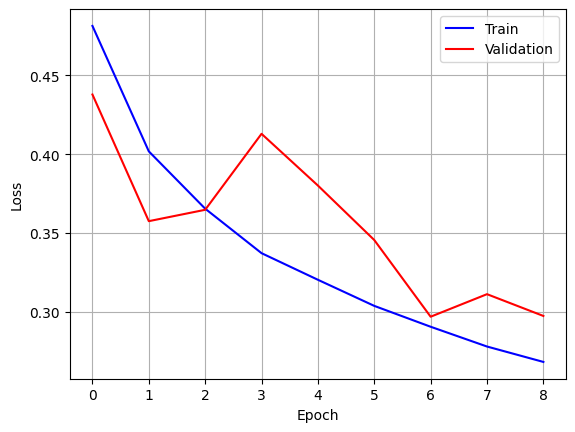

In [67]:
import matplotlib.pyplot as plt
plt.plot(range(num_epochs-1), train_losses[1:], 'b-', label='Train')
plt.plot(range(num_epochs-1), test_losses[1:], 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

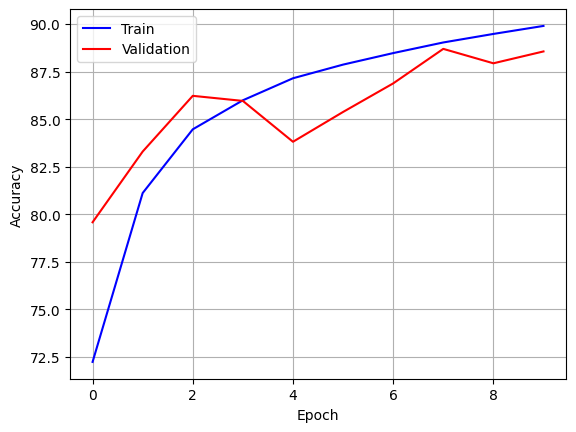

In [68]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), test_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()